In [1]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

from utils.visualize import visualize_bboxes
from utils.helper import fix_bounding_box


In [69]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2, format="xywh"):
    """Visualizes a single bounding box on the image"""
    if format == "xywh":
        x_c, y_c, w, h, dw, dh = bbox

        x_min = int((x_c - w/2) * dw)
        x_max = int((x_c + w/2) * dw) 
        y_min = int((y_c - h/2) * dh)      
        y_max = int((y_c + h/2) * dh)

        print(x_min, y_min, x_max, y_max)
    else:
        x_min, y_min, x_max, y_max = bbox
        x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, format="xywh"):
    color_list = {
        "table": (0,255,0),
        "ref": (255,0,0),
        "object": (0,0,255),
    }
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, color_list[class_name], format=format)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [35]:
filename = "data/dalemkotak/WIN_20240404_15_42_15_Pro"
image = cv2.imread(filename + '.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape
image_viz = image.copy()

In [4]:
# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {
    0: 'table', 
    1: 'ref', 
    2: 'object'
}

In [78]:
def convert_and_normalize_bbox(bbox, image_size):
  """Converts bounding box format and normalizes coordinates.

  Args:
    bbox: A list of bounding box coordinates in the format [xmin, ymin, xmax, ymax].
    image_size: A tuple representing the image size in the format (height, width).

  Returns:
    A list of normalized bounding box coordinates in the format [x_center, y_center, width, height].
  """

  xmin, ymin, xmax, ymax = bbox
  # im_width, im_height = image_size
  im_height, im_width = image_size

  x_center = ((xmax - xmin)/2 + xmin)/im_width 
  y_center = ((ymax - ymin)/2 + ymin)/im_height
  # x_center = ((xmax + xmin) / 2) / im_width  # <-- Calculate center relative to image width
  # y_center = ((ymax + ymin) / 2) / im_height  # <-- Calculate center relative to image height
  width = (xmax - xmin)/im_width
  height = (ymax - ymin)/im_height

  return [x_center, y_center, width, height]

In [77]:
1/2-1

-0.5

[0, 1, 2]
[[673.2530120481927, 331.5662650602409, 1787.7108433734938, 1056.8674698795176], [1110.6024096385543, 559.277108433735, 1346.7469879518071, 784.5783132530121], [1121.4457831325299, 670.1204819277109, 1241.9277108433732, 780.9638554216867]]
AFTER NORMALIZE BBOX
[[0.6403551706827308, 0.6418674698795177, 0.5804467871485943, 0.6715751896474784], [0.6394139056224899, 0.6212293618920125, 0.12299196787148586, 0.20861222668451587], [0.6149410140562248, 0.6708723784024989, 0.06275100401606425, 0.10263275323516281]]
AFTER DENORMALIZE BBOX
675 330 1789 1055
1074 558 1310 783
1227 669 1348 779


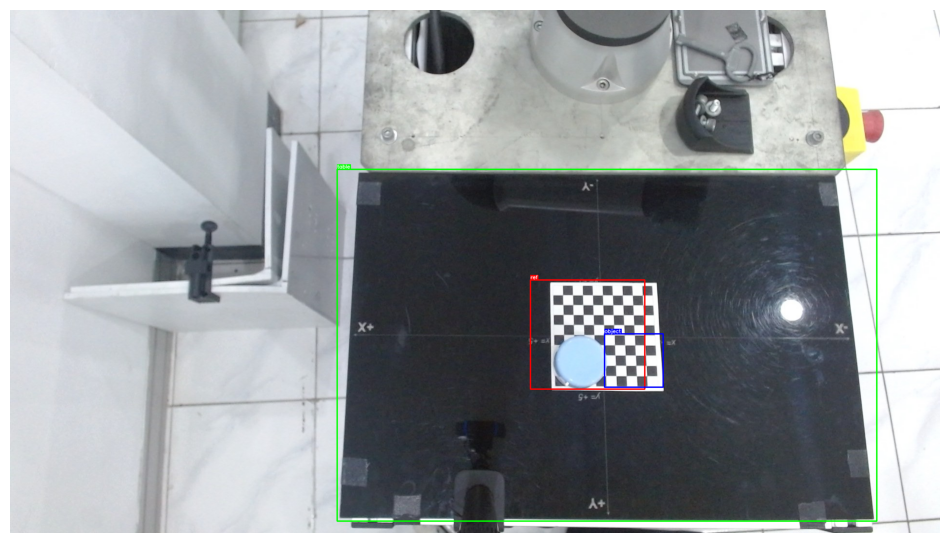

In [79]:
with open(filename + ".txt", "r") as f:
    lines = f.readlines()
    
bboxes = [[float(x) for x in line.split(",")[:4]] for line in lines]
norm_bboxes = [convert_and_normalize_bbox(bb, (image_h, image_w)) for bb in bboxes] # convert to yolo

categories = [line.strip().split(",")[-1] for line in lines]
category_ids = [list(category_id_to_name.keys())[list(category_id_to_name.values()).index(name)] for name in categories]

print(category_ids)
print(bboxes)
print("AFTER NORMALIZE BBOX")
print(norm_bboxes)
print("AFTER DENORMALIZE BBOX")
new_bboxes = [[bbox[1], bbox[1], bbox[2], bbox[3], image_w, image_h] for bbox in norm_bboxes]
# visualize(image_viz, bboxes, category_ids, category_id_to_name, format="xyxy")
visualize(image_viz, new_bboxes, category_ids, category_id_to_name, format="xywh")

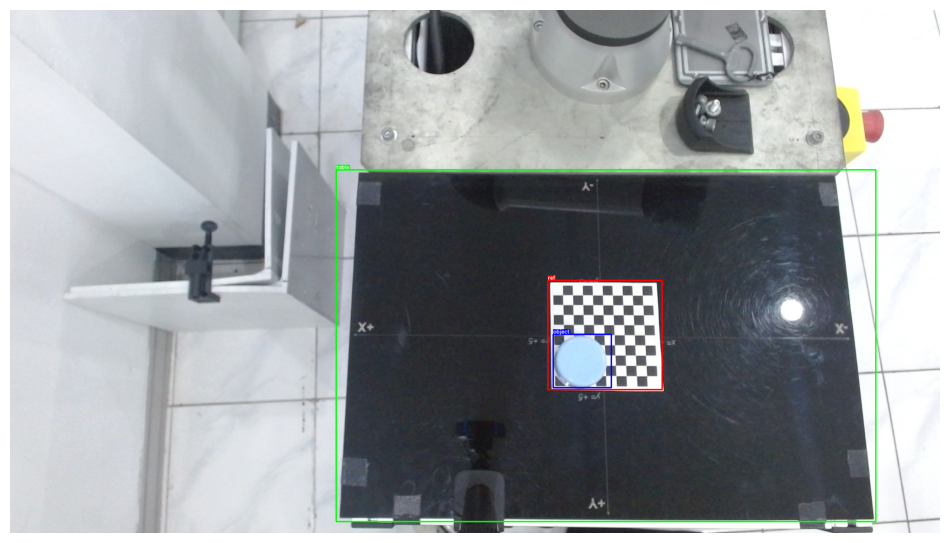

In [45]:
visualize(image_viz, bboxes, category_ids, category_id_to_name, format="xyxy")

In [ ]:
x_min, y_min, w, h, img_w, img_h = bboxes

In [10]:
transform = A.Compose([
        A.RandomBrightnessContrast(p=0.7),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.7),
        A.GaussNoise(p=0.7),
        A.GaussianBlur(p=0.7),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

In [12]:
bboxes

[[721.4457831325301, 337.5903614457831, 1829.879518072289, 1049.6385542168675],
 [1151.566265060241, 562.8915662650603, 1397.3493975903614, 785.7831325301205],
 [1208.1927710843374,
  617.1084337349398,
  1331.0843373493976,
  730.3614457831326]]

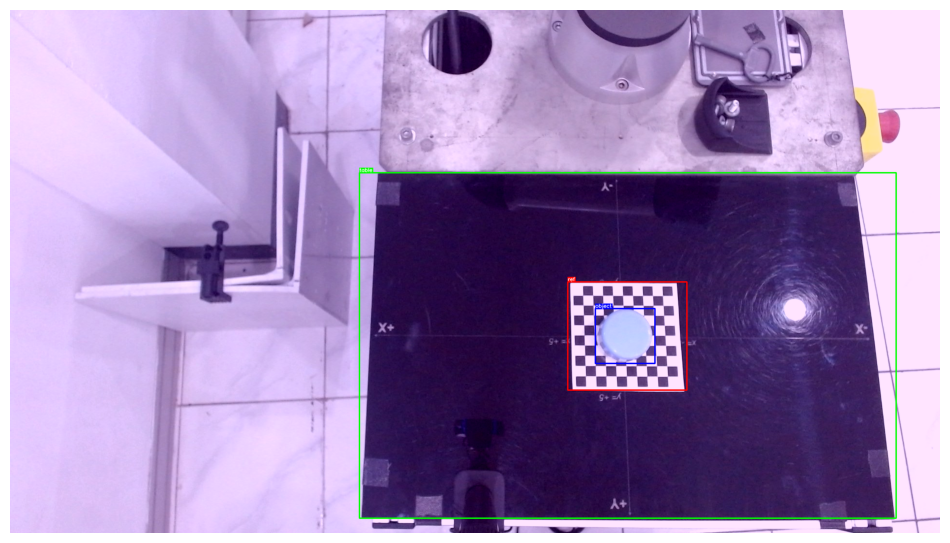

In [14]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
    format='xyxy',
)

In [16]:
transformed.keys()

dict_keys(['image', 'bboxes', 'category_ids'])

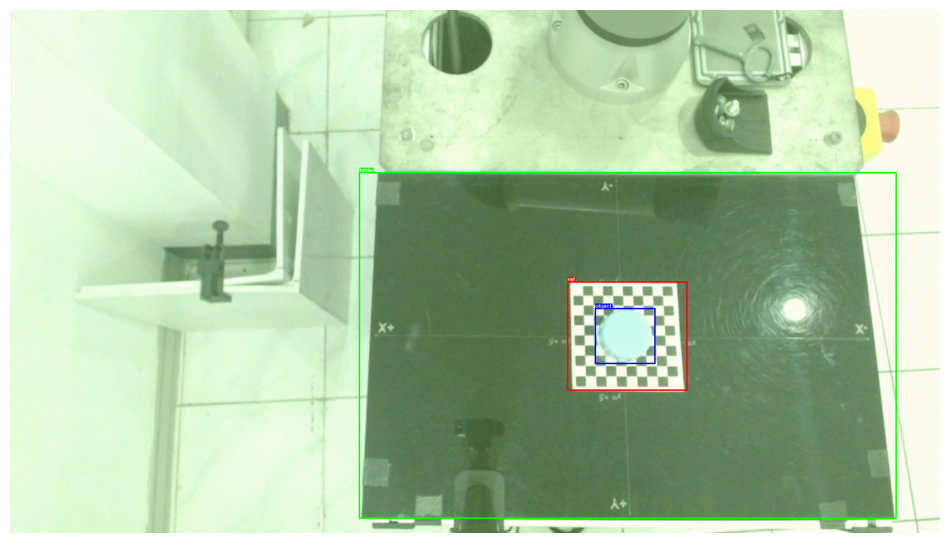

In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [ ]:
transformed['category_ids']

[0, 1, 2]